**BASIC**

In [1]:
import os
#import gym
#import math
#import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#import seaborn
#import datetime
#from dateutil.relativedelta import relativedelta   #for leaping forward by 1 year
#from collections import namedtuple, deque
from itertools import count
#from statsmodels.tsa.stattools import coint, adfuller
#from statsmodels.regression.linear_model import OLS

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

import dqn
from dqn import ReplayMemory, DQN

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [ ]:
#autoreload modified modules
%load_ext autoreload
%autoreload 2

**DATA PIPELINE**

/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


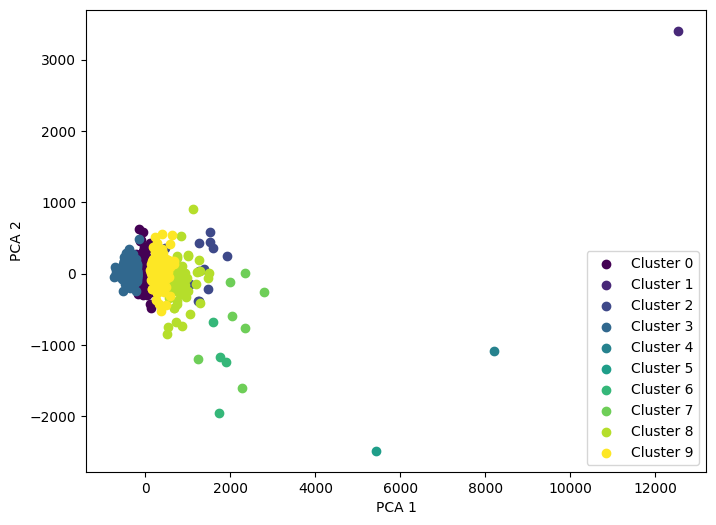

In [2]:
'''
Data pipeline:
    - Read filtered stocks closing prices as CSV/in SQL
    - Find clusters with kmeans and PCA
    - Filter out some outlier clusters; key clusters # as a dict
    - Find cointegration of each key cluster and plot heatmap
'''
import data_pipeline as pipeline
import config

pgConnStr = config.pgDictToConn(config.pgSecrets)

n_clusters = 10
#dailyDF = pd.read_csv('./data/dailyDF', header=0)#, index_col=0, skiprows=0)
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)
clusters = pipeline.findStockClusters(dailyDF, n_clusters)
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)
pipeline.plotStockClusters(clusters)

In [3]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 331 stocks
cluster 2: 15 stocks
cluster 3: 475 stocks
cluster 7: 7 stocks
cluster 8: 64 stocks
cluster 9: 193 stocks


/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


[('CHSCP', 'VLGEA'), ('CHSCP', 'LARK'), ('EML', 'VLGEA'), ('EML', 'LANDO'), ('EML', 'HTD'), ('VLGEA', 'FLIC'), ('MMYT', 'GCBC'), ('OVBC', 'FCBC'), ('REYN', 'GCBC'), ('RILY', 'GPCR'), ('HZO', 'LANDO'), ('HZO', 'BLTE'), ('VSTO', 'RPTX'), ('VSTO', 'GPCR'), ('GOOS', 'BSRR'), ('HTD', 'GPCR'), ('RPTX', 'ARCE'), ('RPTX', 'BLTE'), ('PAM', 'GPCR'), ('ARCE', 'PRG'), ('ARCE', 'GPCR'), ('TRS', 'GPCR'), ('TRS', 'BLTE'), ('PRIM', 'OLP'), ('PEBO', 'RGC'), ('TSBK', 'GPCR'), ('NTB', 'GPCR'), ('NTB', 'BLTE'), ('NTB', 'SRI'), ('GPCR', 'FLIC'), ('GPCR', 'STEP'), ('GPCR', 'OLP'), ('BSRR', 'BLTE'), ('BLTE', 'SRI')]


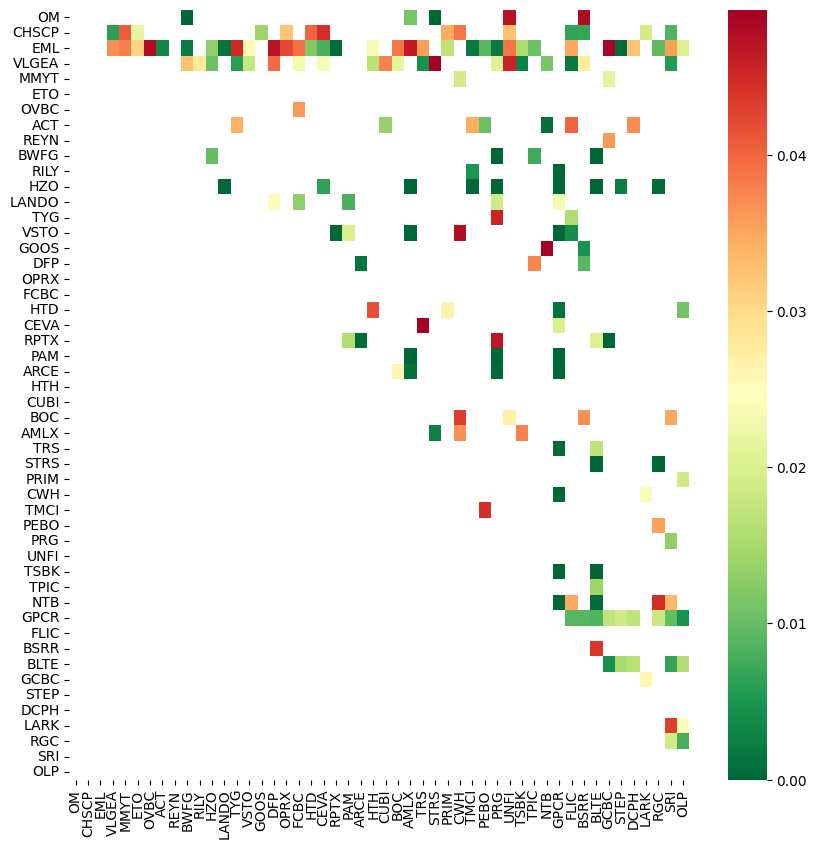

In [4]:
#split train/test data by time: 70/30#
trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF[good_clusters_dict[9]].loc[:round(len(dailyDF)*0.7)].dropna(axis=1, how='all'))

In [5]:
trainpairs

[('CHSCP', 'VLGEA'),
 ('CHSCP', 'LARK'),
 ('EML', 'VLGEA'),
 ('EML', 'LANDO'),
 ('EML', 'HTD'),
 ('VLGEA', 'FLIC'),
 ('MMYT', 'GCBC'),
 ('OVBC', 'FCBC'),
 ('REYN', 'GCBC'),
 ('RILY', 'GPCR'),
 ('HZO', 'LANDO'),
 ('HZO', 'BLTE'),
 ('VSTO', 'RPTX'),
 ('VSTO', 'GPCR'),
 ('GOOS', 'BSRR'),
 ('HTD', 'GPCR'),
 ('RPTX', 'ARCE'),
 ('RPTX', 'BLTE'),
 ('PAM', 'GPCR'),
 ('ARCE', 'PRG'),
 ('ARCE', 'GPCR'),
 ('TRS', 'GPCR'),
 ('TRS', 'BLTE'),
 ('PRIM', 'OLP'),
 ('PEBO', 'RGC'),
 ('TSBK', 'GPCR'),
 ('NTB', 'GPCR'),
 ('NTB', 'BLTE'),
 ('NTB', 'SRI'),
 ('GPCR', 'FLIC'),
 ('GPCR', 'STEP'),
 ('GPCR', 'OLP'),
 ('BSRR', 'BLTE'),
 ('BLTE', 'SRI')]

In [6]:
len(trainpairs)

34

In [7]:
trainpval.shape

(50, 50)

In [18]:
###create trainenvs###
window_size = 60
trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()


In [19]:
len(trainenvs)

16

[('DFP', 'HTH'), ('HTH', 'AUBN'), ('HTH', 'OVBC'), ('HTH', 'STK'), ('ITRN', 'CHSCL'), ('ITRN', 'OVBC'), ('MMYT', 'CHSCL'), ('MMYT', 'CHSCM'), ('MMYT', 'CHSCN'), ('MMYT', 'CAL'), ('MMYT', 'ETD'), ('MMYT', 'GRC'), ('MMYT', 'OVBC'), ('MMYT', 'FMBH'), ('MMYT', 'AROW'), ('MMYT', 'MOFG'), ('AUBN', 'PRO'), ('CHSCM', 'ETD'), ('CAL', 'GRC'), ('CAL', 'MOFG'), ('CUBI', 'PRO')]


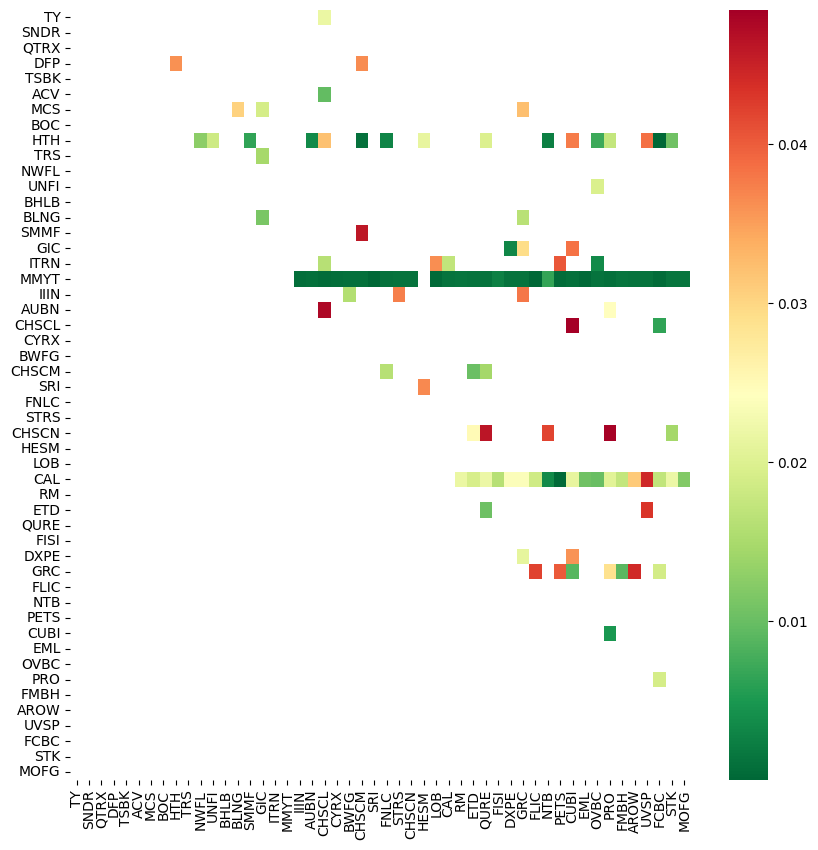

In [21]:
###val set heatmap###
#Remember to use the same cluster as train set
valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF[good_clusters_dict[9]].loc[round(len(dailyDF)*0.7):].dropna(axis=1, how='all'))

In [22]:
len(valpairs)

21

In [23]:
###create valenvs###
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, trade_period, transaction_cost))   #instantiate an env; automatatically run trade()

In [24]:
len(valenvs)

21

**DEEP Q-NETWORK**

**Hyperparameters to tune**
1. Larger memory: 64000 - no visible improvement
2. lr: 1e-2 (R&R = 0, not sensitve at all), 1e-6 (show improving trend but R&R still negative)
3. activation function at output layer: Softmax can get to +ve return but reward still -ve; Sigmoid: +ve R&R! Record high scores!
4. different loss function: MSELoss terrible; L1Loss not impressive; BCELoss record scores! but seems unstable
5. GAMMA, TARGET_UPDATE
6. [more layers]
7. [increase batch size]

In [37]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
#n_actions = 3
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions, device).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions, device).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

#optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)   #from torch.optim; RMSprop = optimizer like SGD or Adam
optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-6)   #from torch.optim; RMSprop = optimizer like SGD or Adam
#memory = ReplayMemory(10000)
memory = ReplayMemory(64000)

steps_done = 0

In [40]:
###training agent###
#num_episodes = 300
num_episodes = 1
best_rewards = -10
for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)   
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = DQN.select_action(state, EPS_START, EPS_END, EPS_DECAY, steps_done, policy_net, n_actions, device)   #epsilon-greedy: exploit or explore; state is this state
            obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            reward = torch.tensor([reward], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each state means 60 past zscores + current action + pvalue
            #each memory pushes 62 + 62 + 2 = 126 
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            #new
            #train_rewards.append(reward)

            # Perform one step of the optimization (on the policy network)
            DQN.optimize_model(memory, BATCH_SIZE, device, policy_net, target_net, GAMMA, optimizer)   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, _reward, done, info = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns)))

print('Complete')

epoch [1/1], train rewards:-31.7056, returns:-12.1746, val rewards:0.7423, returns:1.6470
Complete


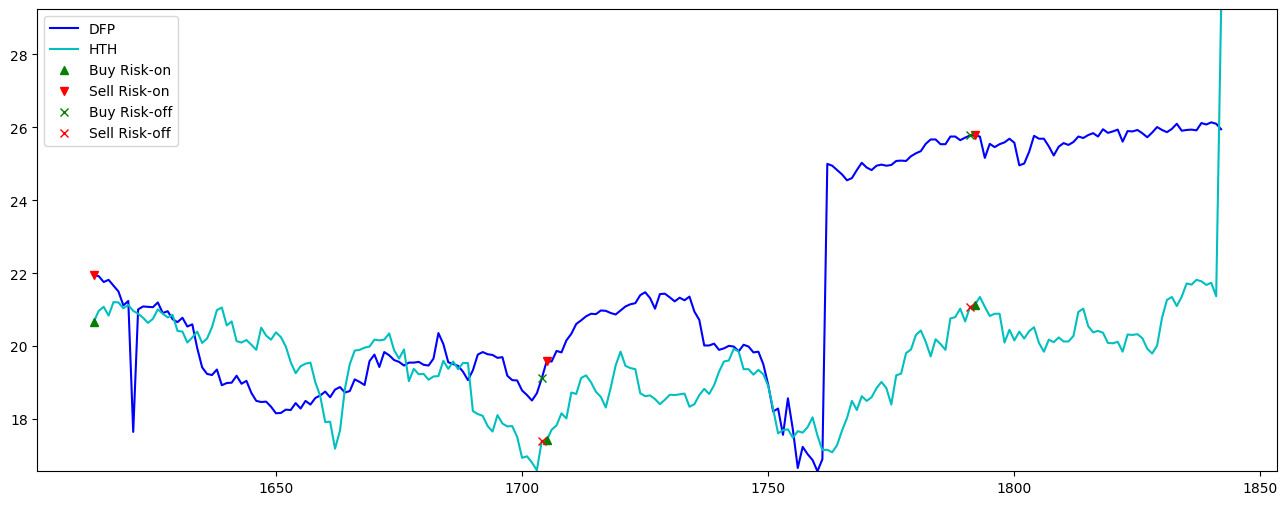

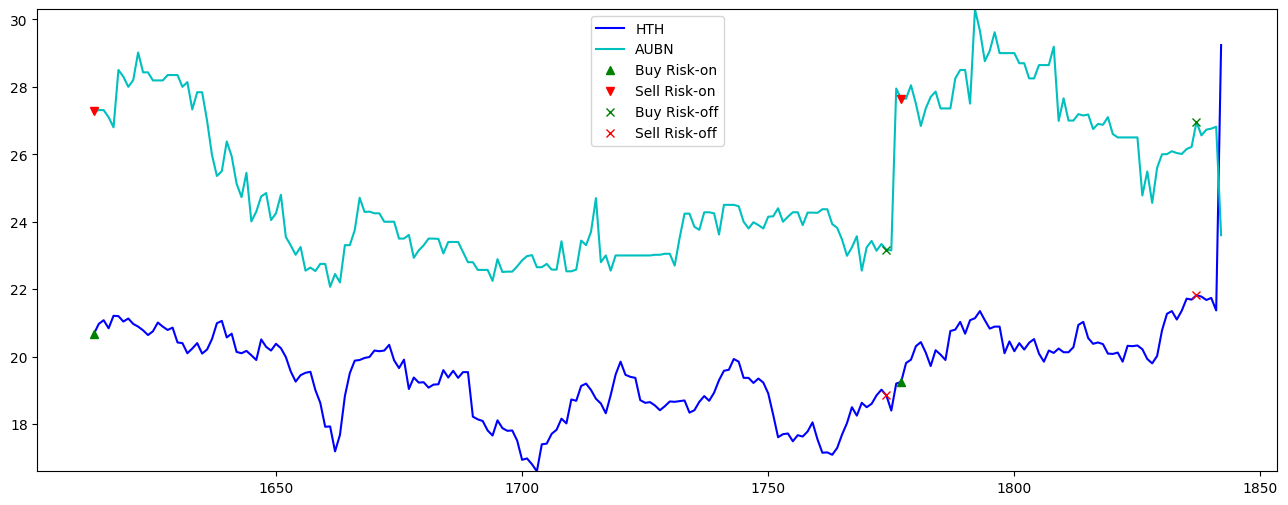

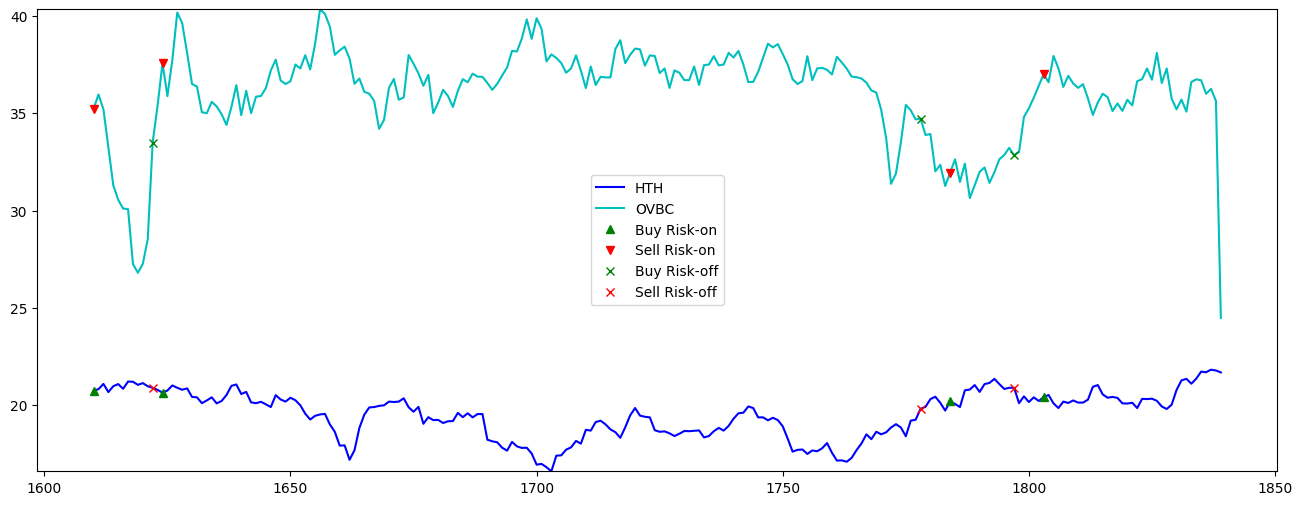

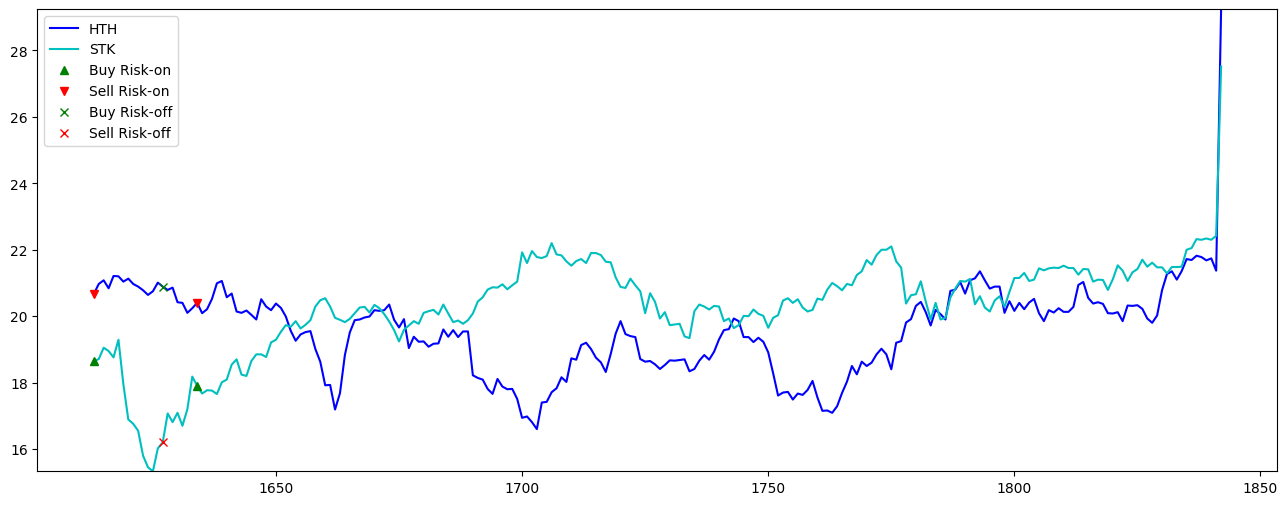

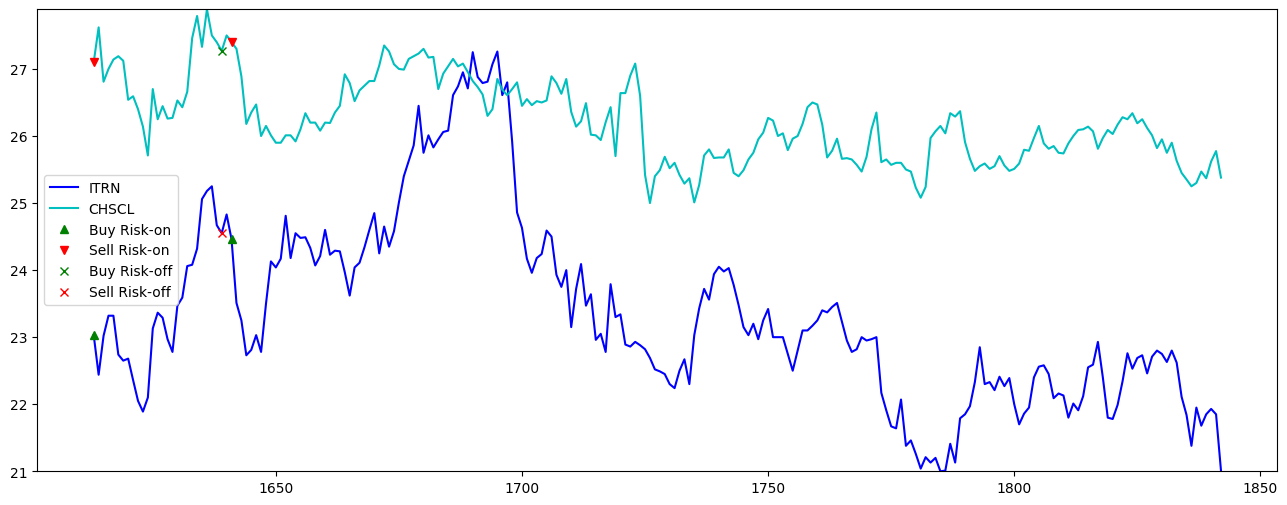

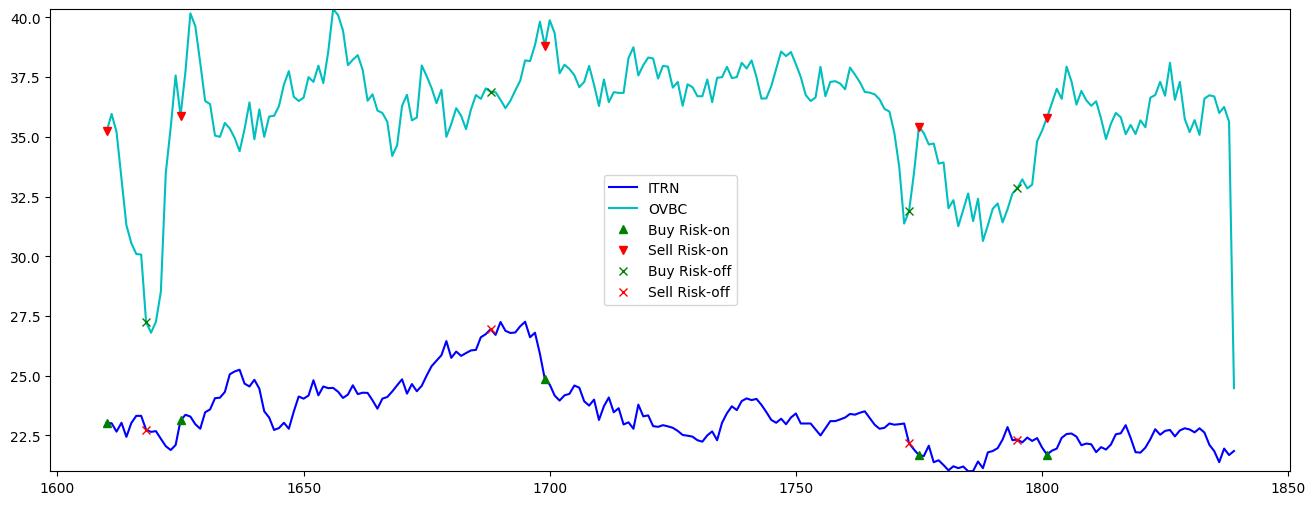

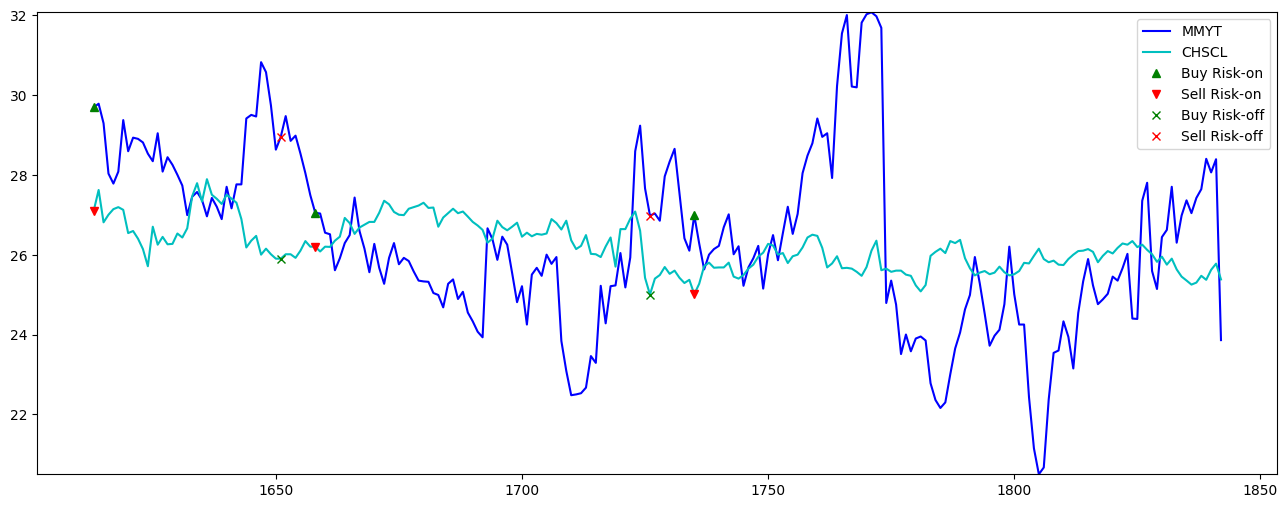

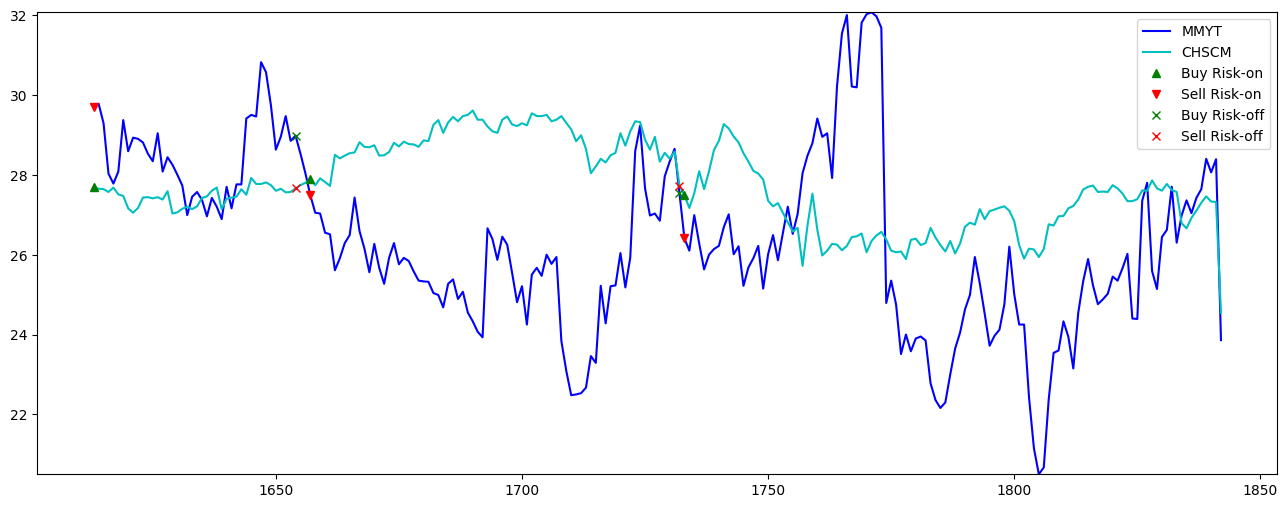

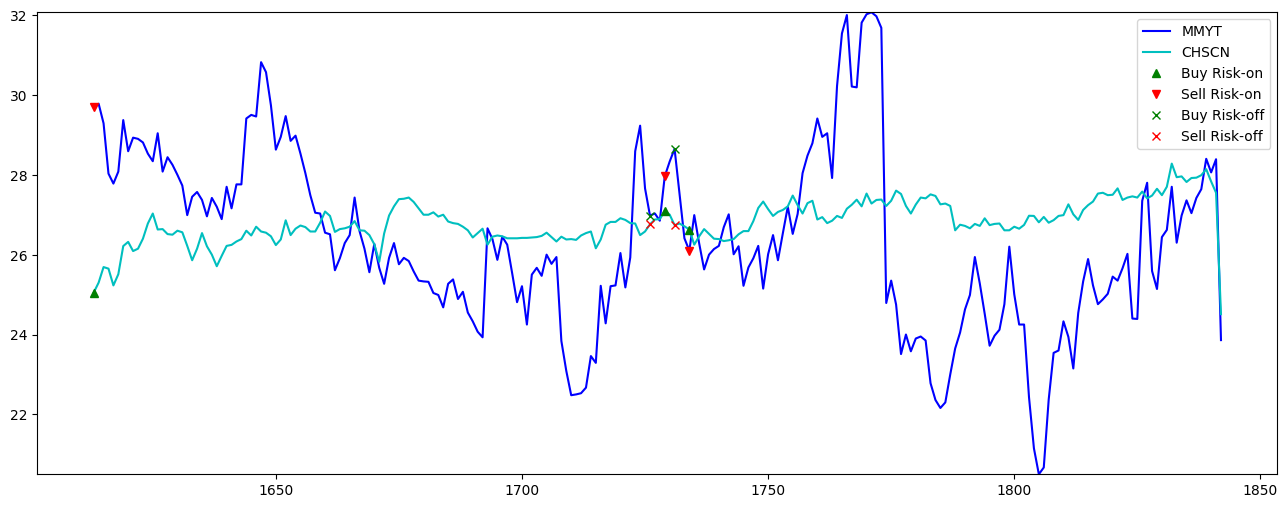

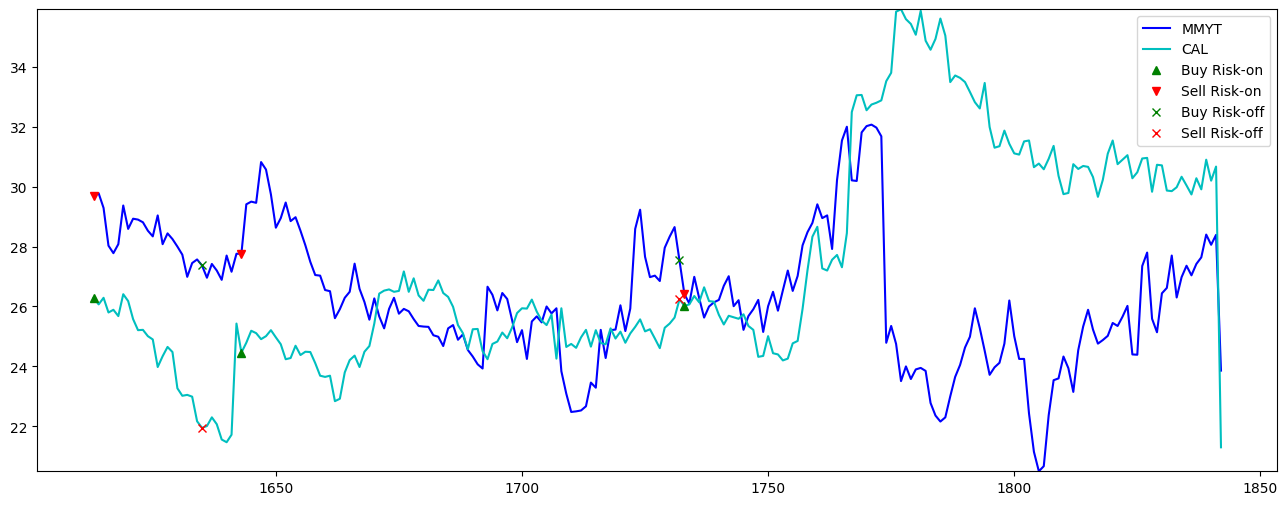

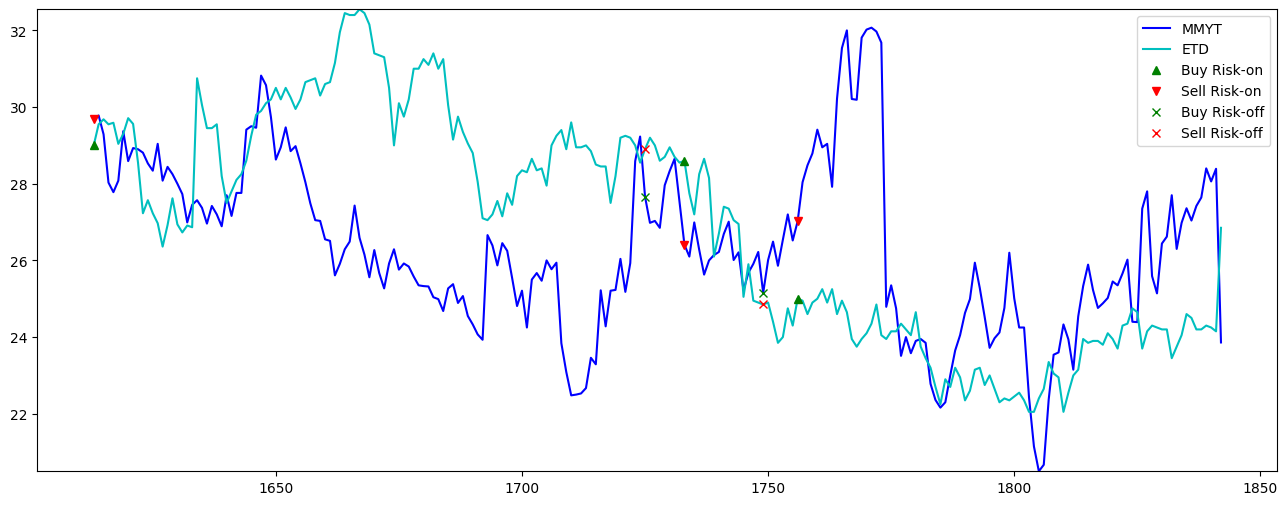

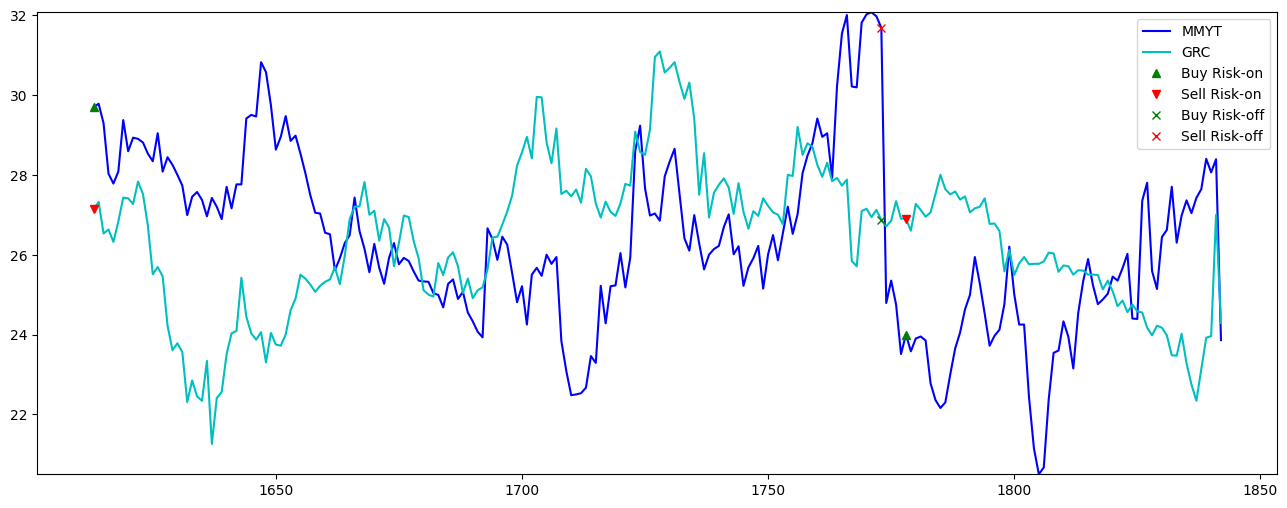

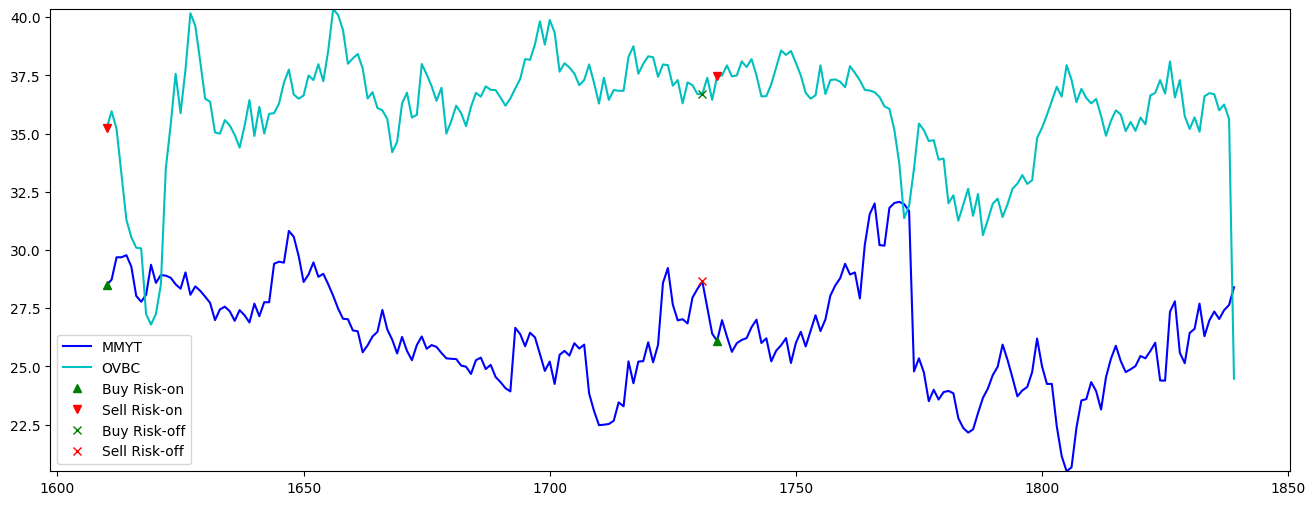

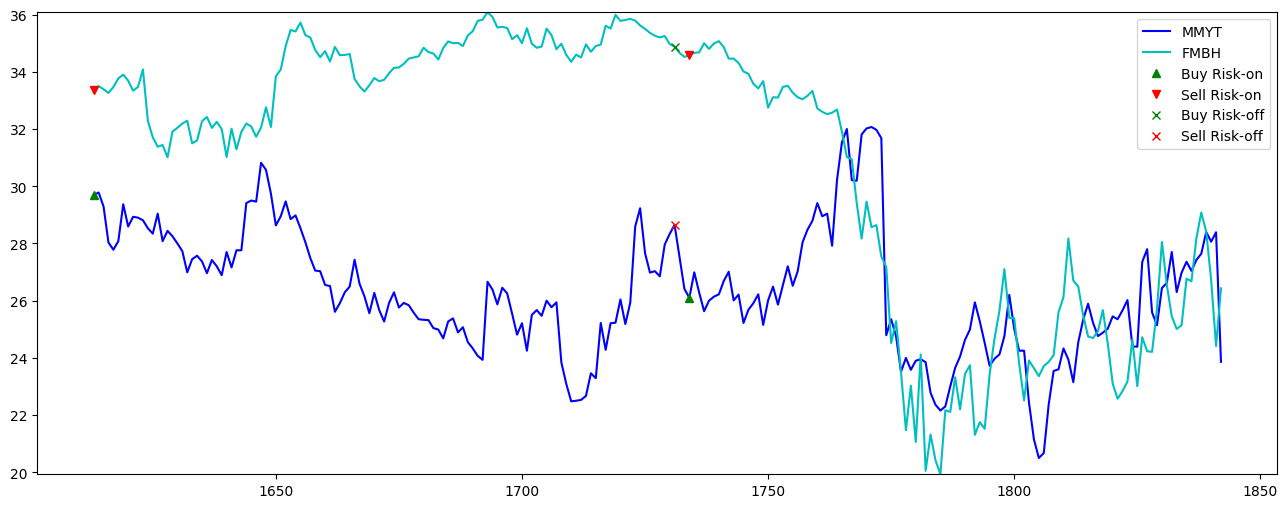

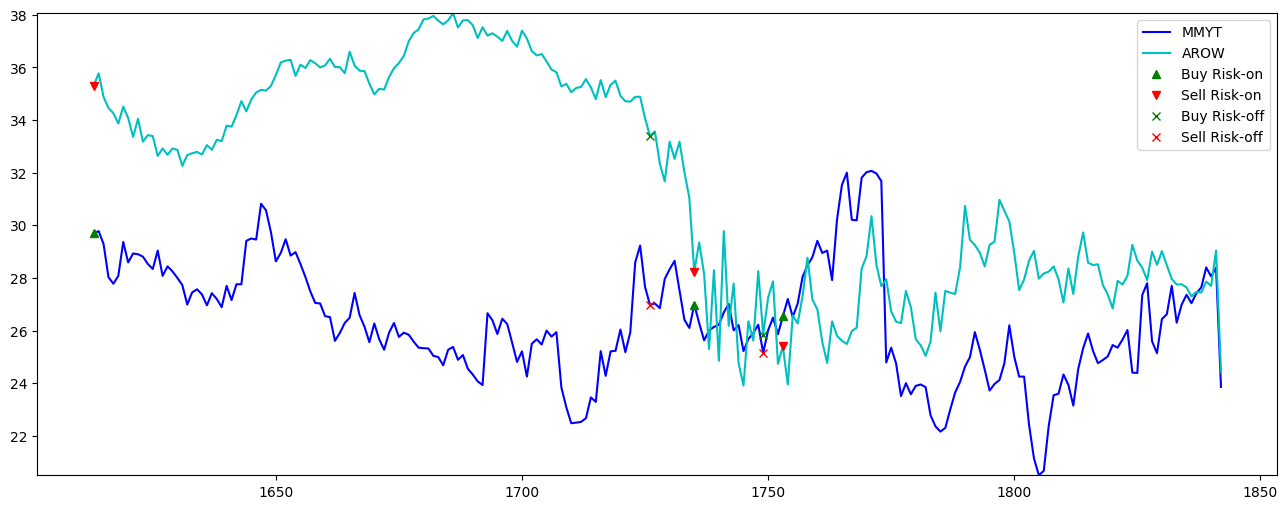

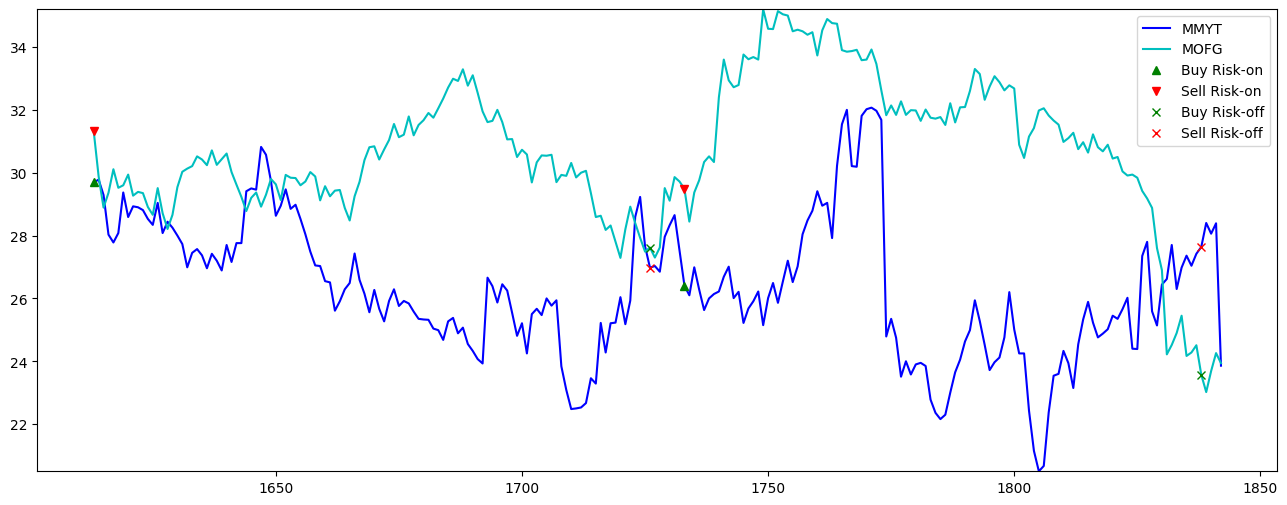

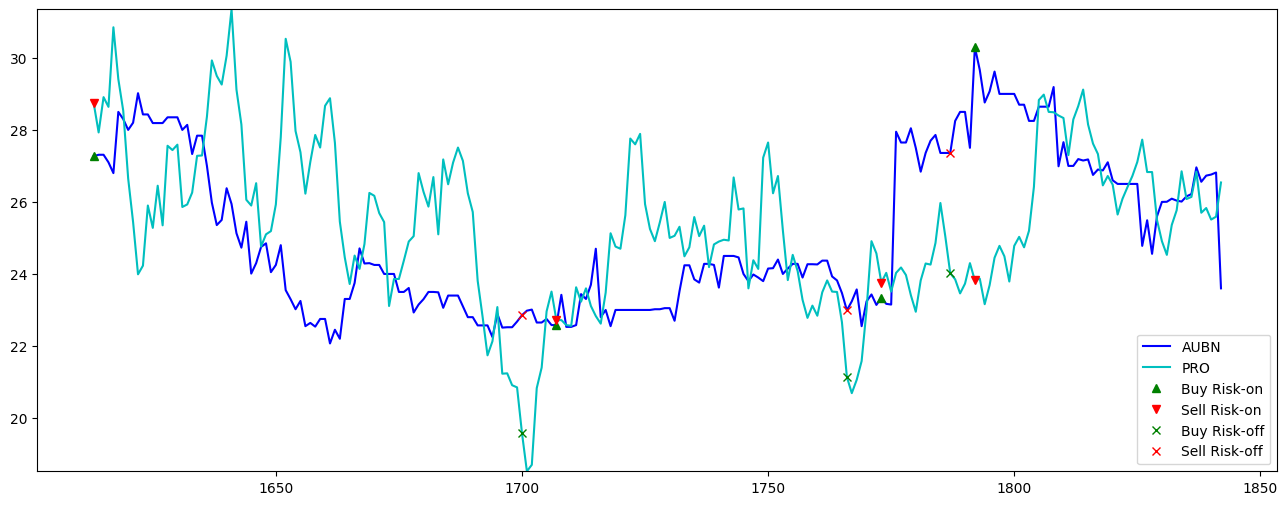

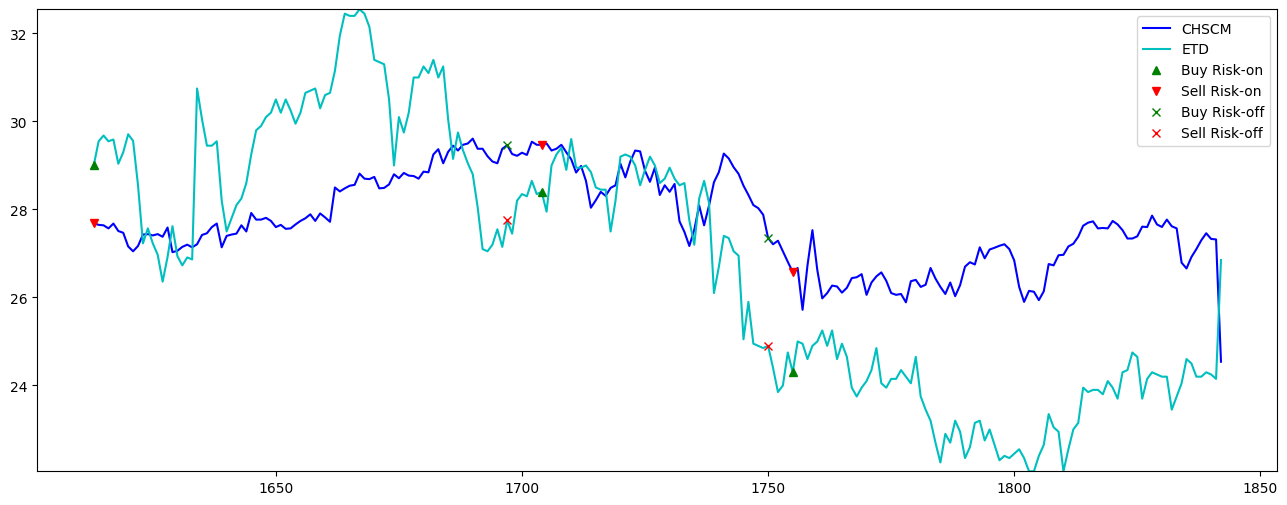

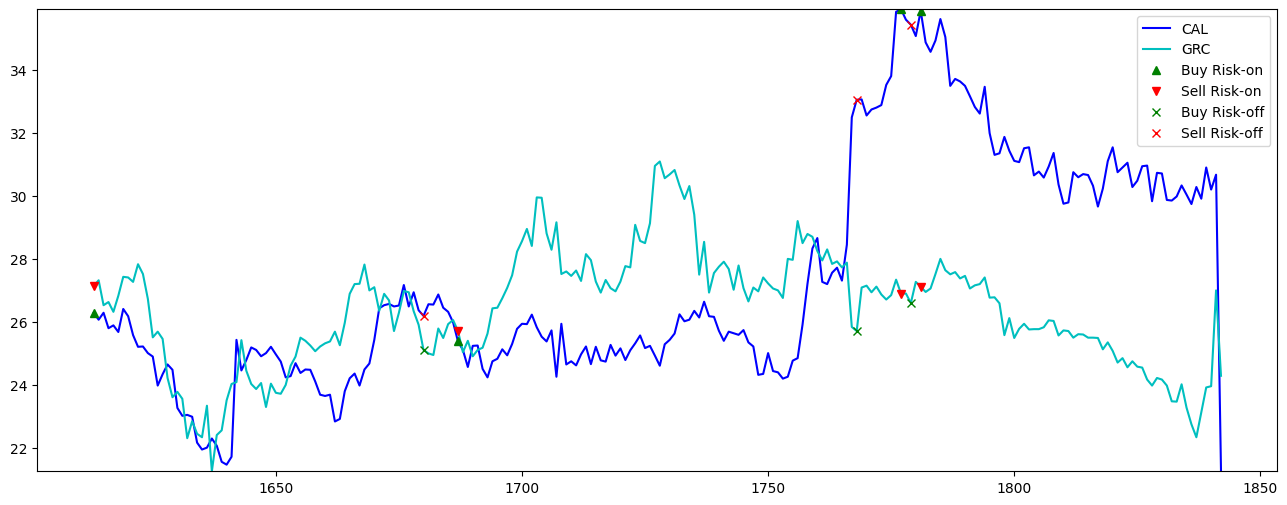

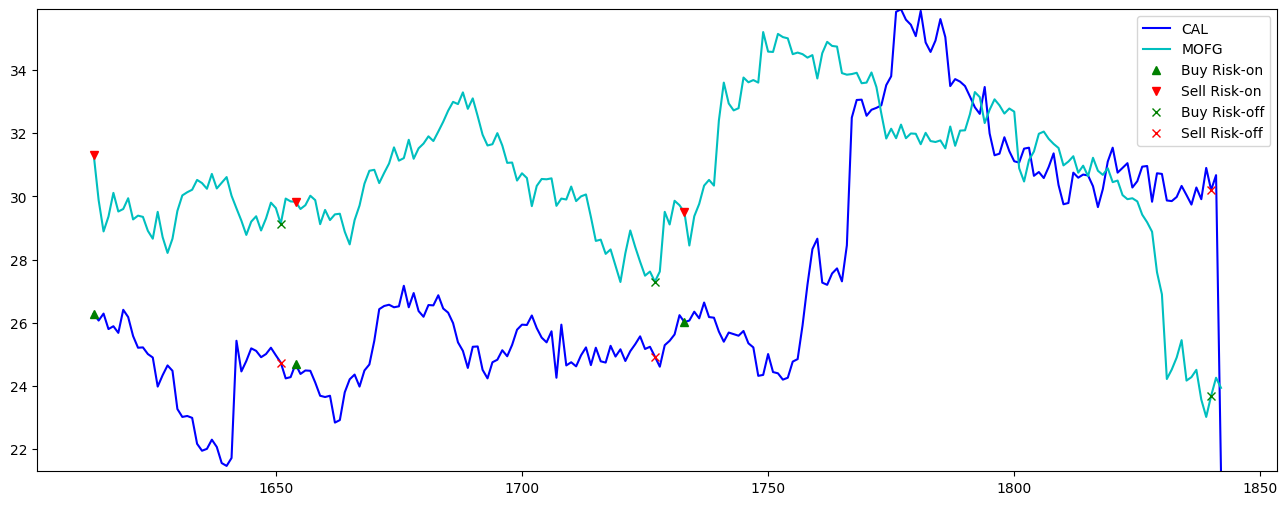

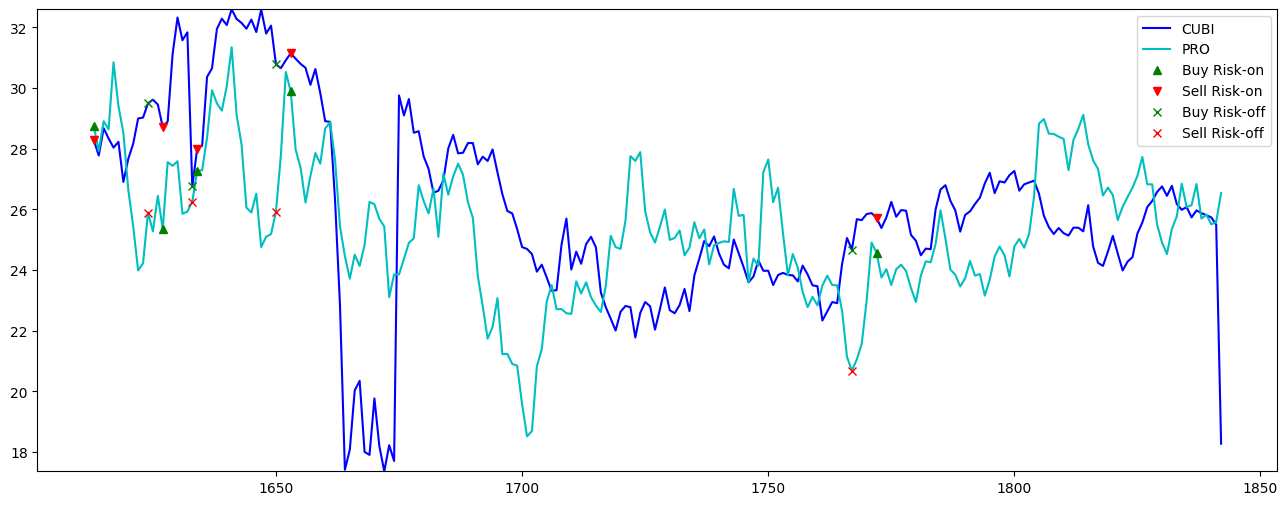

average returns: 3.175581634170262


In [47]:
###plot###
#fill in latest model
#policy_net.load_state_dict(torch.load('./models/model (63).pth'))
policy_net.load_state_dict(torch.load('./models/model (63)_300eps.pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

total_returns = []
with torch.no_grad():
    for valenv in valenvs:
        obs = valenv.reset()
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        for t in count():   #keep looping until done -> break
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, reward, done, info = valenv.step(Positions(action.item()))
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            
            if done:
                valenv.render()   #only rendering the last year
                #total_returns.append(returns)   ###changed###
                #total_returns.append(np.sum(returns))   ###changed###
                total_returns.append(info['total_return'])
                break

#avg_returns = np.mean(returns)
print(f'average returns: {np.mean(total_returns)}')

plt.ioff()
plt.show()